# Лабораторная работа 8  
## Тактовая, частотная и фазовая рассинхронизации
Выполнила: Шаповалова Виктория, ИКТ-11М.  

В данной лабораторной работе собрана приемопередающая система, которая обладает частотной, фазовой и тактовой синхронизацией.

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [63]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import scipy
from scipy import signal
from scipy.signal import max_len_seq
from ModulationPy import PSKModem
from scipy.fftpack import fft, ifft, fftfreq
import time

### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [74]:
data_len = 1024 #длина информационной последовательности
order = 4 #порядок модуляции
mod_shift = 0 #поворот созвездия
offset = 1e3*0 #смещение по частоте
fs = 1e8 #частота дискретизации 
snr = 100 #отношение сигнал/шум
offset_phase = np.pi/6*0 #фазовый сдвиг
delay = 2 #задержка по тактам
sps = 8
N = 21

### 3. Генерация случайного сигнала  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len для дальнейшей передачи.

In [75]:
data = []  
for i in range(data_len):
    data.append(random.randint(0, order-1)) 


### 4. PSK модуляция

В данном разделе определяется модуляция 8-PSK и применяется к сгенерированным ранее данным. Нулевая точка соответствует нулевому значению комплексной плоскости. 

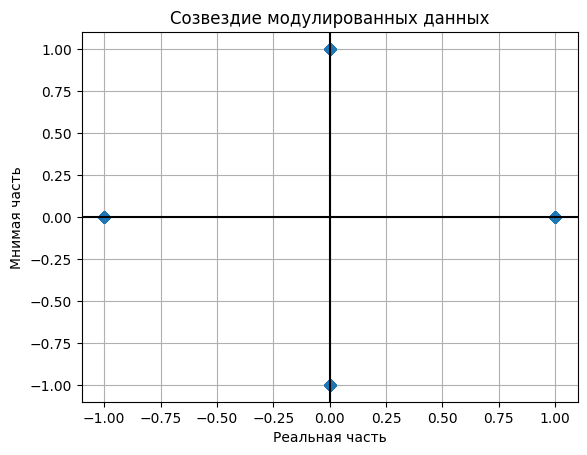

In [76]:
modem = PSKModem(order, mod_shift, 
                 bin_input=False,
                 soft_decision=False,
                 bin_output=False)

data_mod = modem.modulate(data) 

plt.figure(1)
plt.plot(np.real(data_mod),np.imag(data_mod), 'D')
plt.title('Созвездие модулированных данных')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()

### 5. Частотный сдвиг  
В данном разделе к модулированным данным применяется частотный сдвиг.

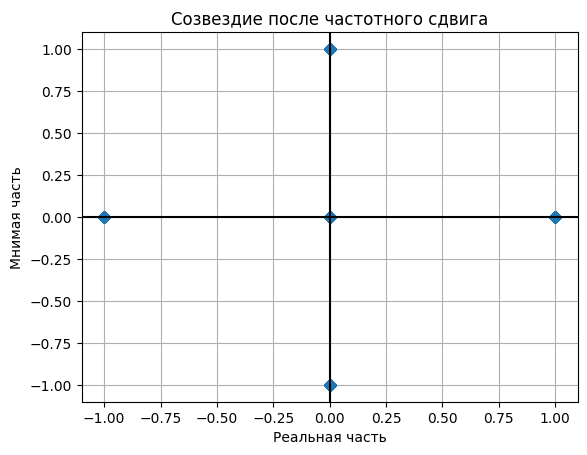

In [77]:
def freq_offset(data, offset, fs):
    Ts = 1/fs 
    t = np.arange(0, Ts*(len(data)-0.5), Ts) 
    data = data * np.exp(1j*2*np.pi*offset*t) 
    return data

upsampled = np.zeros(len(data_mod) * sps, dtype=complex)
upsampled[0::sps] = data_mod  

data_mod_offset = freq_offset(upsampled, offset, fs)
plt.figure(1)
plt.plot(np.real(data_mod_offset),np.imag(data_mod_offset), 'D')
plt.title('Созвездие после частотного сдвига')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()

### 5. Фазовый сдвиг
В данном разделе добавляется фазовый сдвиг.

Text(0.5, 1.0, 'Созвездие сигнала с фазовым сдвигом')

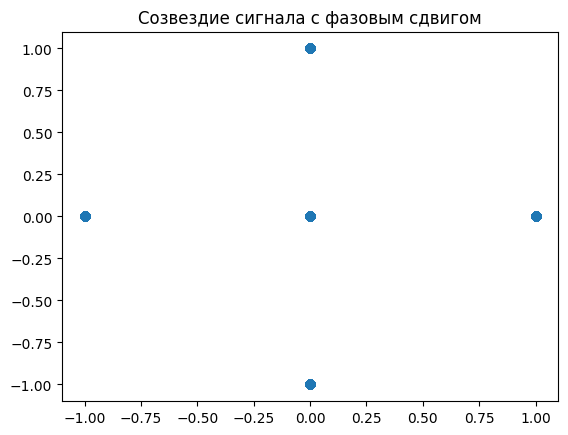

In [78]:
def phase_offset_func(data, phase):
    data = data * np.exp(1j*phase) 
    return data

data_mod_phaseof = phase_offset_func(data_mod_offset, offset_phase)

plt.figure(1)
plt.scatter(np.real(data_mod_phaseof), np.imag(data_mod_phaseof))
plt.title("Созвездие сигнала с фазовым сдвигом")

### 6. Добавление шума 
На следующем шаге производится генерация и добавление АБГШ к данным с частотным и фазовым сдвигом.

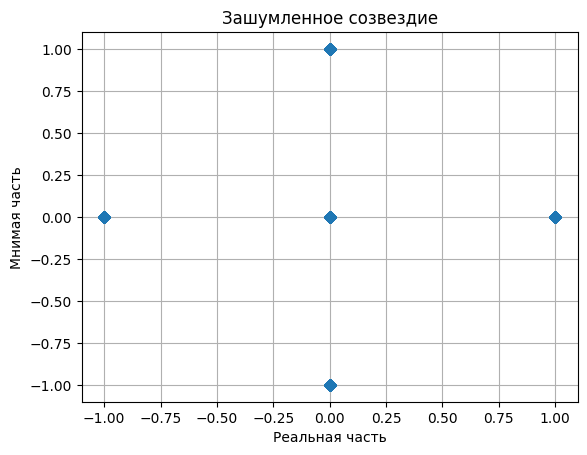

In [79]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

awgn_noise = awgn(data_mod_phaseof, snr)
tx = data_mod_phaseof + awgn_noise

plt.figure(1)
plt.plot(tx.real, tx.imag, 'D')
plt.title('Зашумленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()

### 7. Задержка
На этом шаге вносится задержка во времени к передаваемым данным.

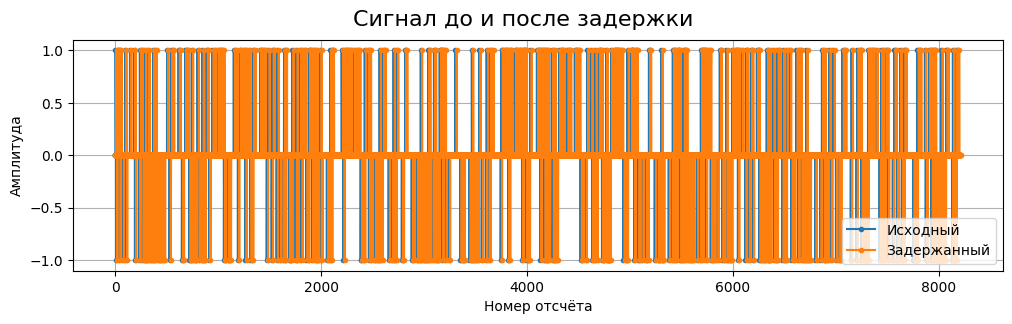

In [80]:
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay)
h *= np.hamming(N) # использование окна Хэмминга для фильтра
h /= np.sum(h) # нормализация, чтобы получить единичный коэффициент усиления и не изменять амплитуду/мощность

fig, ax = plt.subplots(1,figsize=(12,3))
fig.suptitle("Сигнал до и после задержки", fontsize=16)
plt.plot(tx, '.-', label = 'Исходный')

tx_shift = np.convolve(tx, h) # применение фильтра

plt.plot(tx_shift, '.-', label = 'Задержанный')
ax.legend()
plt.grid()
plt.xlabel("Номер отсчёта")
plt.ylabel("Амплитуда")
plt.show()

### 8. Система восстановления. Тактовая синхронизация
Далее сигнал передается на приемную часть, в ходе которой должны быть выполнены тактовая, частотная и фазовая синхронизации, а также демодуляция.  
В первую очередь выполнена тактовая синхронизация по схеме Мюллера-Мюллера.

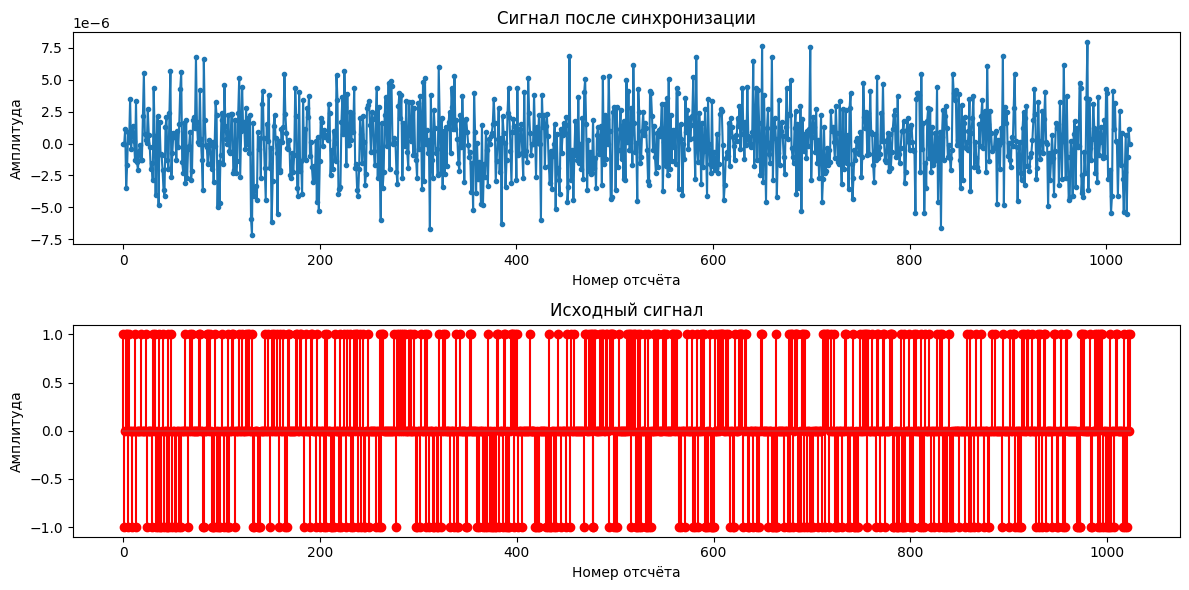

In [81]:
rx = tx_shift
def syncMM(rx, sps):
    mu = 0 
    out = np.zeros(len(rx) + 10, dtype=np.complex64)
    out_rail = np.zeros(len(rx) + 10, dtype=np.complex64) 
    i_in = 0 
    i_out = 2 
    while i_out < len(rx) and i_in + 16 < len(rx):
        out[i_out] = rx[i_in] 
        out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
        x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
        y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
        mm_val = np.real(y - x)
        mu += sps + 0.3*mm_val
        i_in += int(np.floor(mu)) 
        mu = mu - np.floor(mu) 
        i_out += 1
    out = out[2:i_out] 
    return(out)

rx_sync = syncMM(rx, sps)

fig, ((ax1, ax2)) = plt.subplots(2,1, figsize = (12,6))

ax1.title.set_text('Сигнал после синхронизации')
ax1.plot(rx_sync, '.-')
ax1.set_xlabel("Номер отсчёта")
ax1.set_ylabel("Амплитуда")


ax2.title.set_text('Исходный сигнал')
ax2.stem(data_mod, 'r')
ax2.set_xlabel("Номер отсчёта")
ax2.set_ylabel("Амплитуда")

plt.tight_layout()
plt.show()

### 9. Частотная синхронизация  


-292423.1226781628


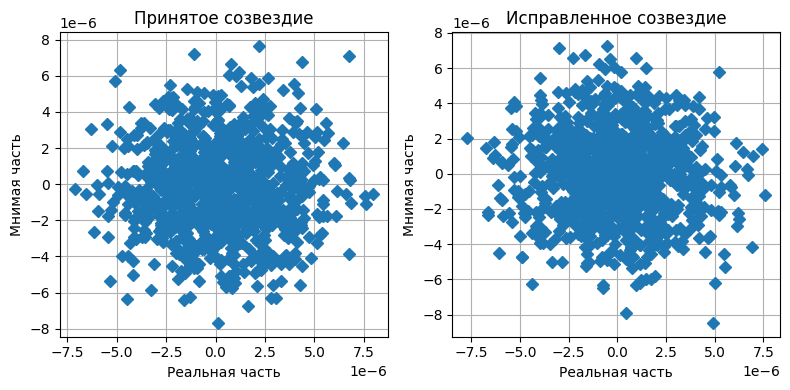

In [82]:
rx_sync = rx_sync[:len(data_mod)]
err_data = rx_sync * np.conj(1*data_mod.real + 1j*data_mod.imag)

def count_v (err_data, data_len):
    sum_func = 0
    for i in range(1,data_len-1,1):
        gamma = (3*data_len)/(2*(data_len**2-1))*(1-((2*i-data_len)/data_len)**2)
        z = (err_data.real[i] + 1j*err_data.imag[i])*(err_data.real[i-1] - 1j*err_data.imag[i-1])
        arg = math.atan2(z.imag, z.real)
        sum_func = sum_func + gamma*arg
    v = fs/(2*np.pi)*sum_func
    return(v)

v = count_v(err_data, data_len)
print(v)

Ts = 1/fs
t = np.arange(0, Ts*(len(data)-0.5), Ts) 
rx_freq = rx_sync * np.exp(-1j*2*np.pi*v*t) 

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(rx_sync.real, rx_sync.imag, 'D')
plt.title('Принятое созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(rx_freq.real, rx_freq.imag, 'D')
plt.title('Исправленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()
plt.tight_layout()

### 10. Фазово-частотная синхронизация

Text(0.5, 0, 'Реальная часть')

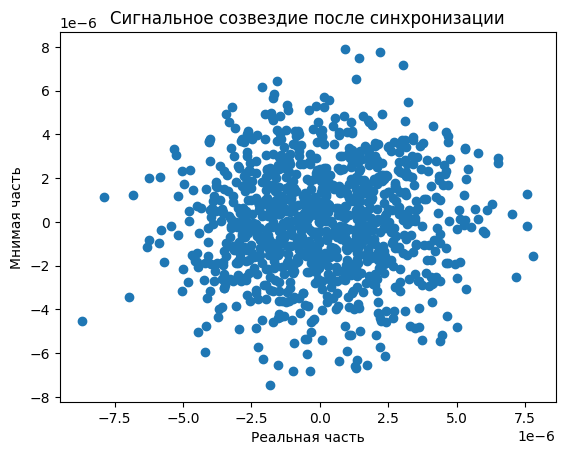

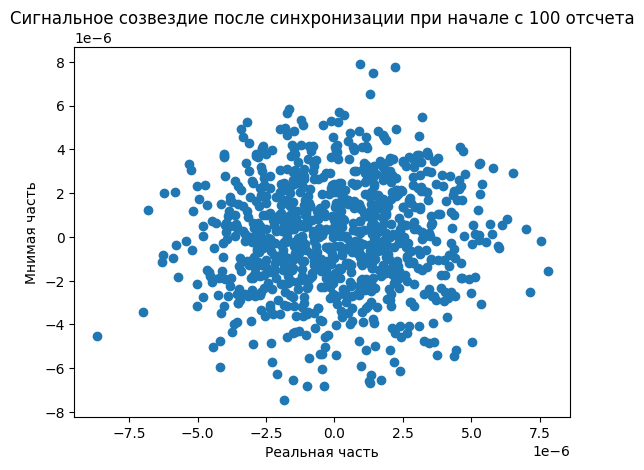

In [83]:
def phase_detector_QPSK(sample):
    ref_point = [np.sqrt(2)/2+(np.sqrt(2)/2)*1j, np.sqrt(2)/2-(np.sqrt(2)/2)*1j, -np.sqrt(2)/2-(np.sqrt(2)/2)*1j, -np.sqrt(2)/2+(np.sqrt(2)/2)*1j]
    distance = np.abs(sample - ref_point)
    ind_min = np.argmin(distance)
    error_angle = np.angle(sample*np.conj(ref_point[ind_min])) 
    return error_angle

def Costas_Loop(tx, fs, alpha, beta):
    N = len(tx)
    phase = 0
    freq = 0
    
    out = np.zeros(N, dtype=np.complex64)
    freq_log = []
    phase_log = []
    error_log = []
    for i in range(N):
        out[i] = tx[i] * np.exp(-1j*phase) 
        error = phase_detector_QPSK(out[i]) 

        freq += (beta * error)
        phase += freq + (alpha * error)
        freq_log.append(freq * fs / (2*np.pi))
        phase_log.append(phase)
        error_log.append(error)
        
    return out


restored_data = Costas_Loop(rx_freq, fs, alpha = 0.05, beta = 0.001)

plt.figure(0)
plt.scatter(np.real(restored_data), np.imag(restored_data))
plt.title(f'Сигнальное созвездие после синхронизации')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")

plt.figure(1)
plt.scatter(np.real(restored_data[100:data_len]), np.imag(restored_data[100:data_len]))
plt.title(f'Сигнальное созвездие после синхронизации при начале с 100 отсчета')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
